In [8]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [9]:
# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

def selu_forward(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
    cache = X
    return out, cache

def selu_backward(dout, cache):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    X = cache
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
    return dX

# p_dropout = keep_prob
def selu_dropout_forward(h, q):
    '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    alpha_p = -scale * alpha
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = (mask * h) + ((1 - mask) * alpha_p)
    a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
    b = -a * (1 - q) * alpha_p
    out = (a * dropped) + b
    cache = (a, mask)
    return out, cache

def selu_dropout_backward(dout, cache):
    a, mask = cache
    d_dropped = dout * a
    dh = d_dropped * mask
    return dh

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [10]:
# But, how do we initialize B, the fixed-random matrix?
# Let me summarize both initializations for you:
# Lillicrap’s B were sampled from a uniform distribution in the range of
# -0.5 to 0.5.
# Nøkland’s B were sampled from a uniform distribution in the range of
# [−1/√fanout, 1/√fanout]
# fanout: the number of inputs that can be connected to a specified output.
D = 2
H= 3
np.random.randn(D, H) / np.sqrt(D / 2.), np.random.uniform(low=-0.5, high=0.5, size=(D, H)), np.random.uniform(low= (-1./np.sqrt(D)), high=(1./np.sqrt(D)), size=(D, H))

(array([[-0.20440721,  2.49302746,  0.98729385],
        [ 1.20849947,  1.23471936,  0.90151452]]),
 array([[ 0.08897284,  0.23757702, -0.44273927],
        [ 0.24259661, -0.3744405 ,  0.34546899]]),
 array([[-0.17964842,  0.65576582, -0.66647448],
        [ 0.17007776,  0.32311674,  0.09524021]]))

In [11]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L, p_dropout):
#         self.mode = 'classification'
        self.L = L # number of layers or depth
#         self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        
        # Input layer
        m = dict(W=np.random.randn(D, H) / np.sqrt(D / 2.), # ff weight - flexible/ adaptive/ learnable
                 b=np.zeros((1, H)))
        self.model.append(m)
        
        # Input layer fixed weight for feedback
#         m = np.random.randn(D, H) / np.sqrt(D / 2.) # fb weight - fixed
        m = np.random.uniform(low= (-1./np.sqrt(D)), high=(1./np.sqrt(D)), size=(D, H))
#         m = np.random.uniform(low=-0.5, high=0.5), size=(D, H))
        self.W_fixed.append(m)

        # Hidden layers
        m = dict(W=np.random.randn(H, H) / np.sqrt(H / 2.), # ff weight - adaptive
                 b=np.zeros((1, H)))
        m_L = []
        for _ in range(L):
            m_L.append(m)
        self.model.append(m_L)
        
        # Hidden layers fixed weight feedback alignment
#         m = np.random.randn(H, H) / np.sqrt(H / 2.)
        m = np.random.uniform(low= (-1./np.sqrt(H)), high=(1./np.sqrt(H)), size=(H, H))
        self.W_fixed.append(m)
        
        # Output layer
        m = dict(W=np.random.randn(H, C) / np.sqrt(H / 2.), # ff weight - adaptive
                 b=np.zeros((1, C)),
                 W_fixed=np.random.randn(H, C) / np.sqrt(H / 2.)) # fb weight - fixed
        self.model.append(m)
        
        # Output layer fixed weight for feedback alignment
#         m = np.random.randn(H, C) / np.sqrt(H / 2.)
        m = np.random.uniform(low= (-1./np.sqrt(H)), high=(1./np.sqrt(H)), size=(H, C))
        self.W_fixed.append(m)
        
    def fc_forward(self, X, model):
        W, b = model['W'], model['b']
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
#         print('db.shape', db.shape)
#         dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
#         y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, fc_cache = self.fc_forward(X=X, model=self.model[0]) # X_1xD, y_1xc
        y, nl_cache = selu_forward(X=y)
        X = y.copy() # pass the previous output to the next layer
        caches.append((fc_cache, nl_cache)) # caches[0]
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
#             y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, fc_cache = self.fc_forward(X=X, model=self.model[1][layer])
            y, nl_cache = selu_forward(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
            nl_caches.append(nl_cache)
        caches.append((fc_caches, nl_caches)) # caches[1]
        
        # Output layer
#         y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y, fc_cache = self.fc_forward(X=X, model=self.model[2])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
#         grads = self.model.copy()
#         print('dy.shape', dy.shape)
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy() # pass it to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db
#         print('''grads[2]['W'].shape, grads[2]['b'].shape''', grads[2]['W'].shape, grads[2]['b'].shape)

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = selu_backward(dout=dy, cache=nl_caches[layer])
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
#             print('''grads[1][]layer['W'].shape, grads[1][layer]['b'].shape''', grads[1][layer]['W'].shape, 
#                   grads[1][layer]['b'].shape)
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = selu_backward(dout=dy, cache=nl_cache)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db
#         print('''grads[0]['W'].shape, grads[0]['b'].shape''', grads[0]['W'].shape, grads[0]['b'].shape)

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Momentums
        M, R = [], []

        # Input layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers momentum
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        # Output layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
 
        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            # Shuffle in every iteration
            # The dataset is static and non-sequentiol: no time-dependency or temporal pattern
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]
#                 M[0][key] = l.exp_running_avg(M[0][key], grads[0][key], beta1)
#                 R[0][key] = l.exp_running_avg(R[0][key], grads[0][key]**2, beta2)
#                 m_k_hat = M[0][key] / (1. - (beta1**(iter)))
#                 r_k_hat = R[0][key] / (1. - (beta2**(iter)))
#                 self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]
#                     M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grads[1][layer][key], beta1)
#                     R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grads[1][layer][key]**2, beta2)
#                     m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
#                     r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))
#                     self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
#                 M[2][key] = l.exp_running_avg(M[2][key], grads[2][key], beta1)
#                 R[2][key] = l.exp_running_avg(R[2][key], grads[2][key]**2, beta2)
#                 m_k_hat = M[2][key] / (1. - (beta1**(iter)))
#                 r_k_hat = R[2][key] / (1. - (beta2**(iter)))
#                 self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [12]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# NOT used now
p_dropout = 0.95 #  layer & unit noise: keep_prob = p_dropout, q = 1-p, 0.95 or 0.90 by default, noise at the network level or layers


# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

nn.adam(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 3.0591 valid loss: 3.0599, valid accuracy: 0.0608
Iter-20 train loss: 2.9647 valid loss: 3.0509, valid accuracy: 0.0632
Iter-30 train loss: 3.1849 valid loss: 3.0412, valid accuracy: 0.0636
Iter-40 train loss: 2.9782 valid loss: 3.0318, valid accuracy: 0.0646
Iter-50 train loss: 3.2150 valid loss: 3.0230, valid accuracy: 0.0648
Iter-60 train loss: 2.8700 valid loss: 3.0136, valid accuracy: 0.0658
Iter-70 train loss: 2.9629 valid loss: 3.0052, valid accuracy: 0.0658
Iter-80 train loss: 2.9305 valid loss: 2.9969, valid accuracy: 0.0672
Iter-90 train loss: 3.1197 valid loss: 2.9899, valid accuracy: 0.0674
Iter-100 train loss: 3.0295 valid loss: 2.9828, valid accuracy: 0.0672
Iter-110 train loss: 2.8472 valid loss: 2.9756, valid accuracy: 0.0674
Iter-120 train loss: 2.9774 valid loss: 2.9684, valid accuracy: 0.0688
Iter-130 train loss: 3.2362 valid loss: 2.9612, valid accuracy: 0.0690
Iter-140 train loss: 3.2176 valid loss: 2.9542, valid accuracy: 0.0698
Iter-150 train 

Iter-1170 train loss: 2.4458 valid loss: 2.3974, valid accuracy: 0.1440
Iter-1180 train loss: 2.4070 valid loss: 2.3916, valid accuracy: 0.1448
Iter-1190 train loss: 2.3666 valid loss: 2.3864, valid accuracy: 0.1456
Iter-1200 train loss: 2.2057 valid loss: 2.3805, valid accuracy: 0.1468
Iter-1210 train loss: 2.3230 valid loss: 2.3751, valid accuracy: 0.1482
Iter-1220 train loss: 2.3971 valid loss: 2.3698, valid accuracy: 0.1494
Iter-1230 train loss: 2.5170 valid loss: 2.3643, valid accuracy: 0.1504
Iter-1240 train loss: 2.3465 valid loss: 2.3589, valid accuracy: 0.1518
Iter-1250 train loss: 2.2979 valid loss: 2.3539, valid accuracy: 0.1524
Iter-1260 train loss: 2.3899 valid loss: 2.3489, valid accuracy: 0.1528
Iter-1270 train loss: 2.5057 valid loss: 2.3431, valid accuracy: 0.1532
Iter-1280 train loss: 2.4079 valid loss: 2.3377, valid accuracy: 0.1542
Iter-1290 train loss: 2.2328 valid loss: 2.3325, valid accuracy: 0.1564
Iter-1300 train loss: 2.4511 valid loss: 2.3278, valid accuracy:

Iter-2310 train loss: 1.8536 valid loss: 1.8984, valid accuracy: 0.3300
Iter-2320 train loss: 1.9083 valid loss: 1.8949, valid accuracy: 0.3318
Iter-2330 train loss: 2.0854 valid loss: 1.8912, valid accuracy: 0.3332
Iter-2340 train loss: 1.9733 valid loss: 1.8877, valid accuracy: 0.3346
Iter-2350 train loss: 1.9227 valid loss: 1.8839, valid accuracy: 0.3358
Iter-2360 train loss: 1.9262 valid loss: 1.8803, valid accuracy: 0.3368
Iter-2370 train loss: 1.9802 valid loss: 1.8768, valid accuracy: 0.3382
Iter-2380 train loss: 1.9217 valid loss: 1.8733, valid accuracy: 0.3404
Iter-2390 train loss: 1.7460 valid loss: 1.8702, valid accuracy: 0.3430
Iter-2400 train loss: 1.8564 valid loss: 1.8666, valid accuracy: 0.3448
Iter-2410 train loss: 1.8110 valid loss: 1.8631, valid accuracy: 0.3452
Iter-2420 train loss: 1.9021 valid loss: 1.8598, valid accuracy: 0.3460
Iter-2430 train loss: 1.9344 valid loss: 1.8564, valid accuracy: 0.3476
Iter-2440 train loss: 1.7646 valid loss: 1.8527, valid accuracy:

Iter-3450 train loss: 1.5049 valid loss: 1.5290, valid accuracy: 0.4980
Iter-3460 train loss: 1.5374 valid loss: 1.5262, valid accuracy: 0.4996
Iter-3470 train loss: 1.5282 valid loss: 1.5235, valid accuracy: 0.5000
Iter-3480 train loss: 1.6483 valid loss: 1.5208, valid accuracy: 0.5010
Iter-3490 train loss: 1.3861 valid loss: 1.5179, valid accuracy: 0.5030
Iter-3500 train loss: 1.4984 valid loss: 1.5152, valid accuracy: 0.5034
Iter-3510 train loss: 1.5955 valid loss: 1.5125, valid accuracy: 0.5046
Iter-3520 train loss: 1.5746 valid loss: 1.5098, valid accuracy: 0.5066
Iter-3530 train loss: 1.4634 valid loss: 1.5069, valid accuracy: 0.5080
Iter-3540 train loss: 1.5696 valid loss: 1.5041, valid accuracy: 0.5094
Iter-3550 train loss: 1.4502 valid loss: 1.5013, valid accuracy: 0.5110
Iter-3560 train loss: 1.5068 valid loss: 1.4987, valid accuracy: 0.5128
Iter-3570 train loss: 1.4921 valid loss: 1.4959, valid accuracy: 0.5136
Iter-3580 train loss: 1.4462 valid loss: 1.4933, valid accuracy:

Iter-4590 train loss: 1.2610 valid loss: 1.2530, valid accuracy: 0.6170
Iter-4600 train loss: 1.3573 valid loss: 1.2510, valid accuracy: 0.6174
Iter-4610 train loss: 1.4144 valid loss: 1.2489, valid accuracy: 0.6178
Iter-4620 train loss: 1.3578 valid loss: 1.2468, valid accuracy: 0.6188
Iter-4630 train loss: 1.1404 valid loss: 1.2449, valid accuracy: 0.6194
Iter-4640 train loss: 1.1987 valid loss: 1.2428, valid accuracy: 0.6210
Iter-4650 train loss: 1.3425 valid loss: 1.2408, valid accuracy: 0.6216
Iter-4660 train loss: 1.1098 valid loss: 1.2391, valid accuracy: 0.6224
Iter-4670 train loss: 1.2948 valid loss: 1.2371, valid accuracy: 0.6228
Iter-4680 train loss: 1.3002 valid loss: 1.2350, valid accuracy: 0.6238
Iter-4690 train loss: 1.3896 valid loss: 1.2329, valid accuracy: 0.6262
Iter-4700 train loss: 1.4166 valid loss: 1.2311, valid accuracy: 0.6274
Iter-4710 train loss: 1.1647 valid loss: 1.2290, valid accuracy: 0.6286
Iter-4720 train loss: 1.2127 valid loss: 1.2271, valid accuracy:

Iter-5730 train loss: 1.1047 valid loss: 1.0596, valid accuracy: 0.7002
Iter-5740 train loss: 1.0243 valid loss: 1.0582, valid accuracy: 0.7002
Iter-5750 train loss: 1.0203 valid loss: 1.0569, valid accuracy: 0.7002
Iter-5760 train loss: 1.0531 valid loss: 1.0554, valid accuracy: 0.7004
Iter-5770 train loss: 0.9926 valid loss: 1.0539, valid accuracy: 0.7004
Iter-5780 train loss: 1.0463 valid loss: 1.0525, valid accuracy: 0.7012
Iter-5790 train loss: 0.9435 valid loss: 1.0510, valid accuracy: 0.7018
Iter-5800 train loss: 1.1811 valid loss: 1.0496, valid accuracy: 0.7026
Iter-5810 train loss: 1.0511 valid loss: 1.0483, valid accuracy: 0.7032
Iter-5820 train loss: 1.1701 valid loss: 1.0469, valid accuracy: 0.7040
Iter-5830 train loss: 1.2344 valid loss: 1.0455, valid accuracy: 0.7044
Iter-5840 train loss: 1.3068 valid loss: 1.0440, valid accuracy: 0.7044
Iter-5850 train loss: 1.1176 valid loss: 1.0427, valid accuracy: 0.7048
Iter-5860 train loss: 1.0873 valid loss: 1.0413, valid accuracy:

Iter-6870 train loss: 0.8231 valid loss: 0.9262, valid accuracy: 0.7382
Iter-6880 train loss: 0.8964 valid loss: 0.9252, valid accuracy: 0.7386
Iter-6890 train loss: 1.0318 valid loss: 0.9242, valid accuracy: 0.7388
Iter-6900 train loss: 0.9362 valid loss: 0.9232, valid accuracy: 0.7392
Iter-6910 train loss: 0.9424 valid loss: 0.9222, valid accuracy: 0.7388
Iter-6920 train loss: 1.0194 valid loss: 0.9213, valid accuracy: 0.7394
Iter-6930 train loss: 0.7969 valid loss: 0.9203, valid accuracy: 0.7392
Iter-6940 train loss: 0.9720 valid loss: 0.9194, valid accuracy: 0.7398
Iter-6950 train loss: 0.9532 valid loss: 0.9184, valid accuracy: 0.7404
Iter-6960 train loss: 0.8967 valid loss: 0.9175, valid accuracy: 0.7408
Iter-6970 train loss: 0.9439 valid loss: 0.9165, valid accuracy: 0.7402
Iter-6980 train loss: 0.8140 valid loss: 0.9156, valid accuracy: 0.7398
Iter-6990 train loss: 0.9211 valid loss: 0.9147, valid accuracy: 0.7404
Iter-7000 train loss: 1.0357 valid loss: 0.9138, valid accuracy:

Iter-8010 train loss: 0.7803 valid loss: 0.8323, valid accuracy: 0.7670
Iter-8020 train loss: 0.7916 valid loss: 0.8317, valid accuracy: 0.7670
Iter-8030 train loss: 0.8607 valid loss: 0.8310, valid accuracy: 0.7672
Iter-8040 train loss: 1.0156 valid loss: 0.8302, valid accuracy: 0.7672
Iter-8050 train loss: 0.7459 valid loss: 0.8295, valid accuracy: 0.7668
Iter-8060 train loss: 0.7186 valid loss: 0.8288, valid accuracy: 0.7678
Iter-8070 train loss: 0.7762 valid loss: 0.8281, valid accuracy: 0.7672
Iter-8080 train loss: 0.9164 valid loss: 0.8274, valid accuracy: 0.7670
Iter-8090 train loss: 0.9397 valid loss: 0.8267, valid accuracy: 0.7676
Iter-8100 train loss: 0.8950 valid loss: 0.8260, valid accuracy: 0.7682
Iter-8110 train loss: 0.7203 valid loss: 0.8254, valid accuracy: 0.7686
Iter-8120 train loss: 1.0743 valid loss: 0.8247, valid accuracy: 0.7690
Iter-8130 train loss: 0.9433 valid loss: 0.8241, valid accuracy: 0.7698
Iter-8140 train loss: 0.8493 valid loss: 0.8234, valid accuracy:

Iter-9150 train loss: 0.8428 valid loss: 0.7661, valid accuracy: 0.7904
Iter-9160 train loss: 0.7144 valid loss: 0.7657, valid accuracy: 0.7902
Iter-9170 train loss: 0.7169 valid loss: 0.7652, valid accuracy: 0.7902
Iter-9180 train loss: 0.7732 valid loss: 0.7647, valid accuracy: 0.7904
Iter-9190 train loss: 0.7828 valid loss: 0.7643, valid accuracy: 0.7906
Iter-9200 train loss: 0.9551 valid loss: 0.7639, valid accuracy: 0.7912
Iter-9210 train loss: 0.6783 valid loss: 0.7633, valid accuracy: 0.7914
Iter-9220 train loss: 0.7757 valid loss: 0.7628, valid accuracy: 0.7916
Iter-9230 train loss: 0.7171 valid loss: 0.7624, valid accuracy: 0.7918
Iter-9240 train loss: 0.6265 valid loss: 0.7619, valid accuracy: 0.7922
Iter-9250 train loss: 0.8507 valid loss: 0.7614, valid accuracy: 0.7926
Iter-9260 train loss: 0.6184 valid loss: 0.7609, valid accuracy: 0.7924
Iter-9270 train loss: 0.7270 valid loss: 0.7604, valid accuracy: 0.7924
Iter-9280 train loss: 0.9912 valid loss: 0.7599, valid accuracy:

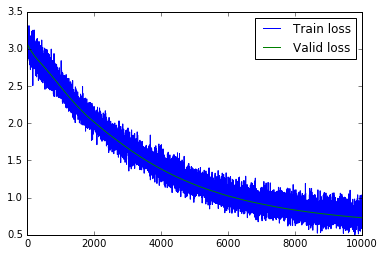

In [15]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

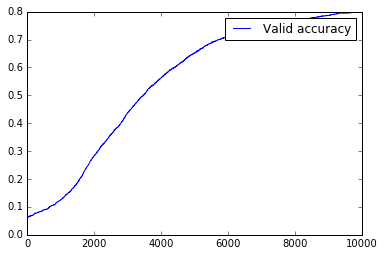

In [16]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()